In [1]:
from data_pipeline.np_dataset import NpDataset
import input_mapping.models_torch as models_torch
from data_pipeline.image_transforms import get_transforms

from data_pipeline.data_package import DataPackage





from PIL import Image
from pydicom import dcmread
import torch
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
import numpy as np

from ai_backend.loggers.model_logger import is_min
from uuid import uuid4
import torch.nn as nn
from torch.optim import Adam
import torch
import json
import os
import re
import tqdm
from ai_backend.evaluators.metrics.multi_label_metrics import  multi_label_f_beta, multi_label_confusion_matrix, multi_label_accuracy, multi_label_precision, multi_label_recal
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd



/home/efarjall/miniconda3/envs/ird/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/efarjall/miniconda3/envs/ird/lib/python3.11/site-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/efarjall/miniconda3/envs/ird/lib/python3.11/site-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home

In [2]:
#checkpoint 1
augmentations = transforms.Compose([
                transforms.RandomRotation(10),
                transforms.RandomHorizontalFlip(p=0.6),
                transforms.RandomVerticalFlip(p=0.5)
            ])

In [3]:
#create np datasets for training, validation and testing
read_dicom = lambda x: dcmread(x).pixel_array
dicom_file_reader = lambda x: Image.fromarray(read_dicom(x)).convert('RGB')
default_file_reader = lambda x: Image.open(x).convert('RGB')


In [4]:
model_id = 'dc318ff6-b424-41fe-bde1-c5be53a13616'
model_key = 'resnet18'
path_to_model_conig = f'models/{model_key}/{model_id}/model_config.json'
#load the model configuration
with open(path_to_model_conig, 'r') as f:
    model_config = json.load(f)

In [5]:
transform_type = model_config['transform_type']
transforms_config = models_torch.model_dict[model_key]['transforms_config']
transform = get_transforms(transform_name = transform_type, transforms_config = transforms_config)
labels_to_encode = np.array(["Age-related Macular Degeneration", "Best Disease", "Bietti crystalline dystrophy",
                              "cataract", "Cone Dystrophie or Cone-rod Dystrophie", "Diabetic Retinopathy",
                              "glaucoma", "Maculopathy", "Myopia", "Normal", "Retinitis Pigmentosa", "Stargardt Disease"])

In [6]:
#train the model
dataset_name = '2024-05-17_12-13-57'
best_model_save_folder = f'models/{model_key}/{model_id}'
best_model_save_path = f'{best_model_save_folder}/weights.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [7]:
def convert_package_to_dataset(package, augmentations=None):
    file_reader = dicom_file_reader if package.data_source_name == 'UKB' else default_file_reader
    dataset = NpDataset(file_paths=package.get_data(), labels=package.get_labels(),
                         file_reader=file_reader, transform=transform, augmentation_transform=augmentations)
    return dataset

def convert_package_list_to_dataset(package_list, augmentations=None):
    datasets = []
    for package in package_list:
        dataset = convert_package_to_dataset(package)
        datasets.append(dataset)
    return datasets

In [8]:
#list the saved directories and load the datapackages
dataset_path = 'datasets/2024-05-17_12-13-57'
train_packages_path = f'{dataset_path}/train'
val_packages_path = f'{dataset_path}/val'
test_packages_path = f'{dataset_path}/test'
package_paths = [train_packages_path, val_packages_path, test_packages_path]
train_packages = []
val_packages = []
test_packages = []
all_packages = [train_packages, val_packages, test_packages]

for path, package_list  in zip(package_paths, all_packages):
    files = os.listdir(path)
    for file in files:
        package = DataPackage.load(f'{path}/{file}')
        package_list.append(package)
#convert to np datasets
train_datasets = convert_package_list_to_dataset(train_packages, augmentations=augmentations)
val_datasets = convert_package_list_to_dataset(val_packages)
test_datasets = convert_package_list_to_dataset(test_packages)


In [9]:
for i, dataset in  enumerate(train_datasets):
    dataset.balance_augmentation()

In [10]:
#concat the datasets
train_dataset = ConcatDataset(train_datasets)
validation_dataset = ConcatDataset(val_datasets)
test_dataset = ConcatDataset(test_datasets)

#create data loaders
num_workers = 0
validation_loader = DataLoader(validation_dataset, batch_size=512, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=512, num_workers=num_workers)

In [11]:
# create model
model = models_torch.get_model(model_name=model_key, num_classes=len(labels_to_encode))


/home/efarjall/miniconda3/envs/ird/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/efarjall/miniconda3/envs/ird/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [12]:
#add dropout forward hooks to the model
for name, module in model.named_modules():
    re_pattern = re.compile(r'^layer\d+$')
    if re_pattern.match(name) is not None:
        print('Adding forward hook for:', name)
        module.register_forward_hook(lambda module, input,
                                      output: torch.nn.functional.dropout2d(output, p=0.2, training=module.training))

Adding forward hook for: layer1
Adding forward hook for: layer2
Adding forward hook for: layer3
Adding forward hook for: layer4


In [13]:
#load the best model
model.load_state_dict(torch.load(best_model_save_path))

<All keys matched successfully>

In [14]:
evaluations_save_folder = f'{best_model_save_folder}/evaluations'
os.makedirs(evaluations_save_folder, exist_ok=True)

In [15]:
#get the predictions for the model
y_true_validation = []
y_pred_validation = []
model.to(device)
model.eval()
with torch.no_grad():
    for inputs, labels in validation_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        y_true_validation.append(labels.detach().clone())
        y_pred_validation.append(outputs.detach().clone())
y_true_validation = torch.cat(y_true_validation, dim=0).cpu()
y_pred_validation = torch.cat(y_pred_validation, dim=0).cpu()

In [ ]:
#find the best threshold for each label
#turn off optuna warnings
step_size = 0.01
iterations = 1/step_size
#set the verbosity to error

best_thresholds = []

for i in range(len(labels_to_encode)):
    best_thresholds.append(0)
    best_score = 0
    #todo fix the max function
    for j in range(int(iterations)):
        threshold = j*step_size
        f1_score = multi_label_f_beta(y_true_validation, y_pred_validation, beta=1.0, averaging_type=None, threshold=threshold)
        if f1_score[i] > best_score:
            best_score = f1_score[i]
            best_thresholds[i] = threshold
    print('Best thresholds found for class', labels_to_encode[i], 'at', best_thresholds[i], 'with a score of', best_score)

best_thresholds = torch.Tensor(best_thresholds)



In [17]:
print('Best thresholds:', best_thresholds.tolist())


Best thresholds: [0.8199999928474426, 0.75, 0.4399999976158142, 0.8399999737739563, 0.23000000417232513, 0.8199999928474426, 0.7900000214576721, 0.33000001311302185, 0.4399999976158142, 0.18000000715255737, 0.47999998927116394, 0.33000001311302185]


In [18]:
#save the best thresholds in the model configuration

model_config['best_thresholds'] = best_thresholds.tolist()
with open(f'{best_model_save_folder}/model_config.json', 'w') as f:
    json.dump(model_config, f)

In [19]:
#execute the model on the test set
y_true = []
y_pred = []
x = []
model.to(device)
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        y_true.append(labels.detach().clone())
        y_pred.append(outputs.detach().clone())
        x.append(inputs.detach().clone())
y_true = torch.cat(y_true, dim=0).cpu()
y_pred = torch.cat(y_pred, dim=0).cpu()
X_test = torch.cat(x, dim=0).cpu()

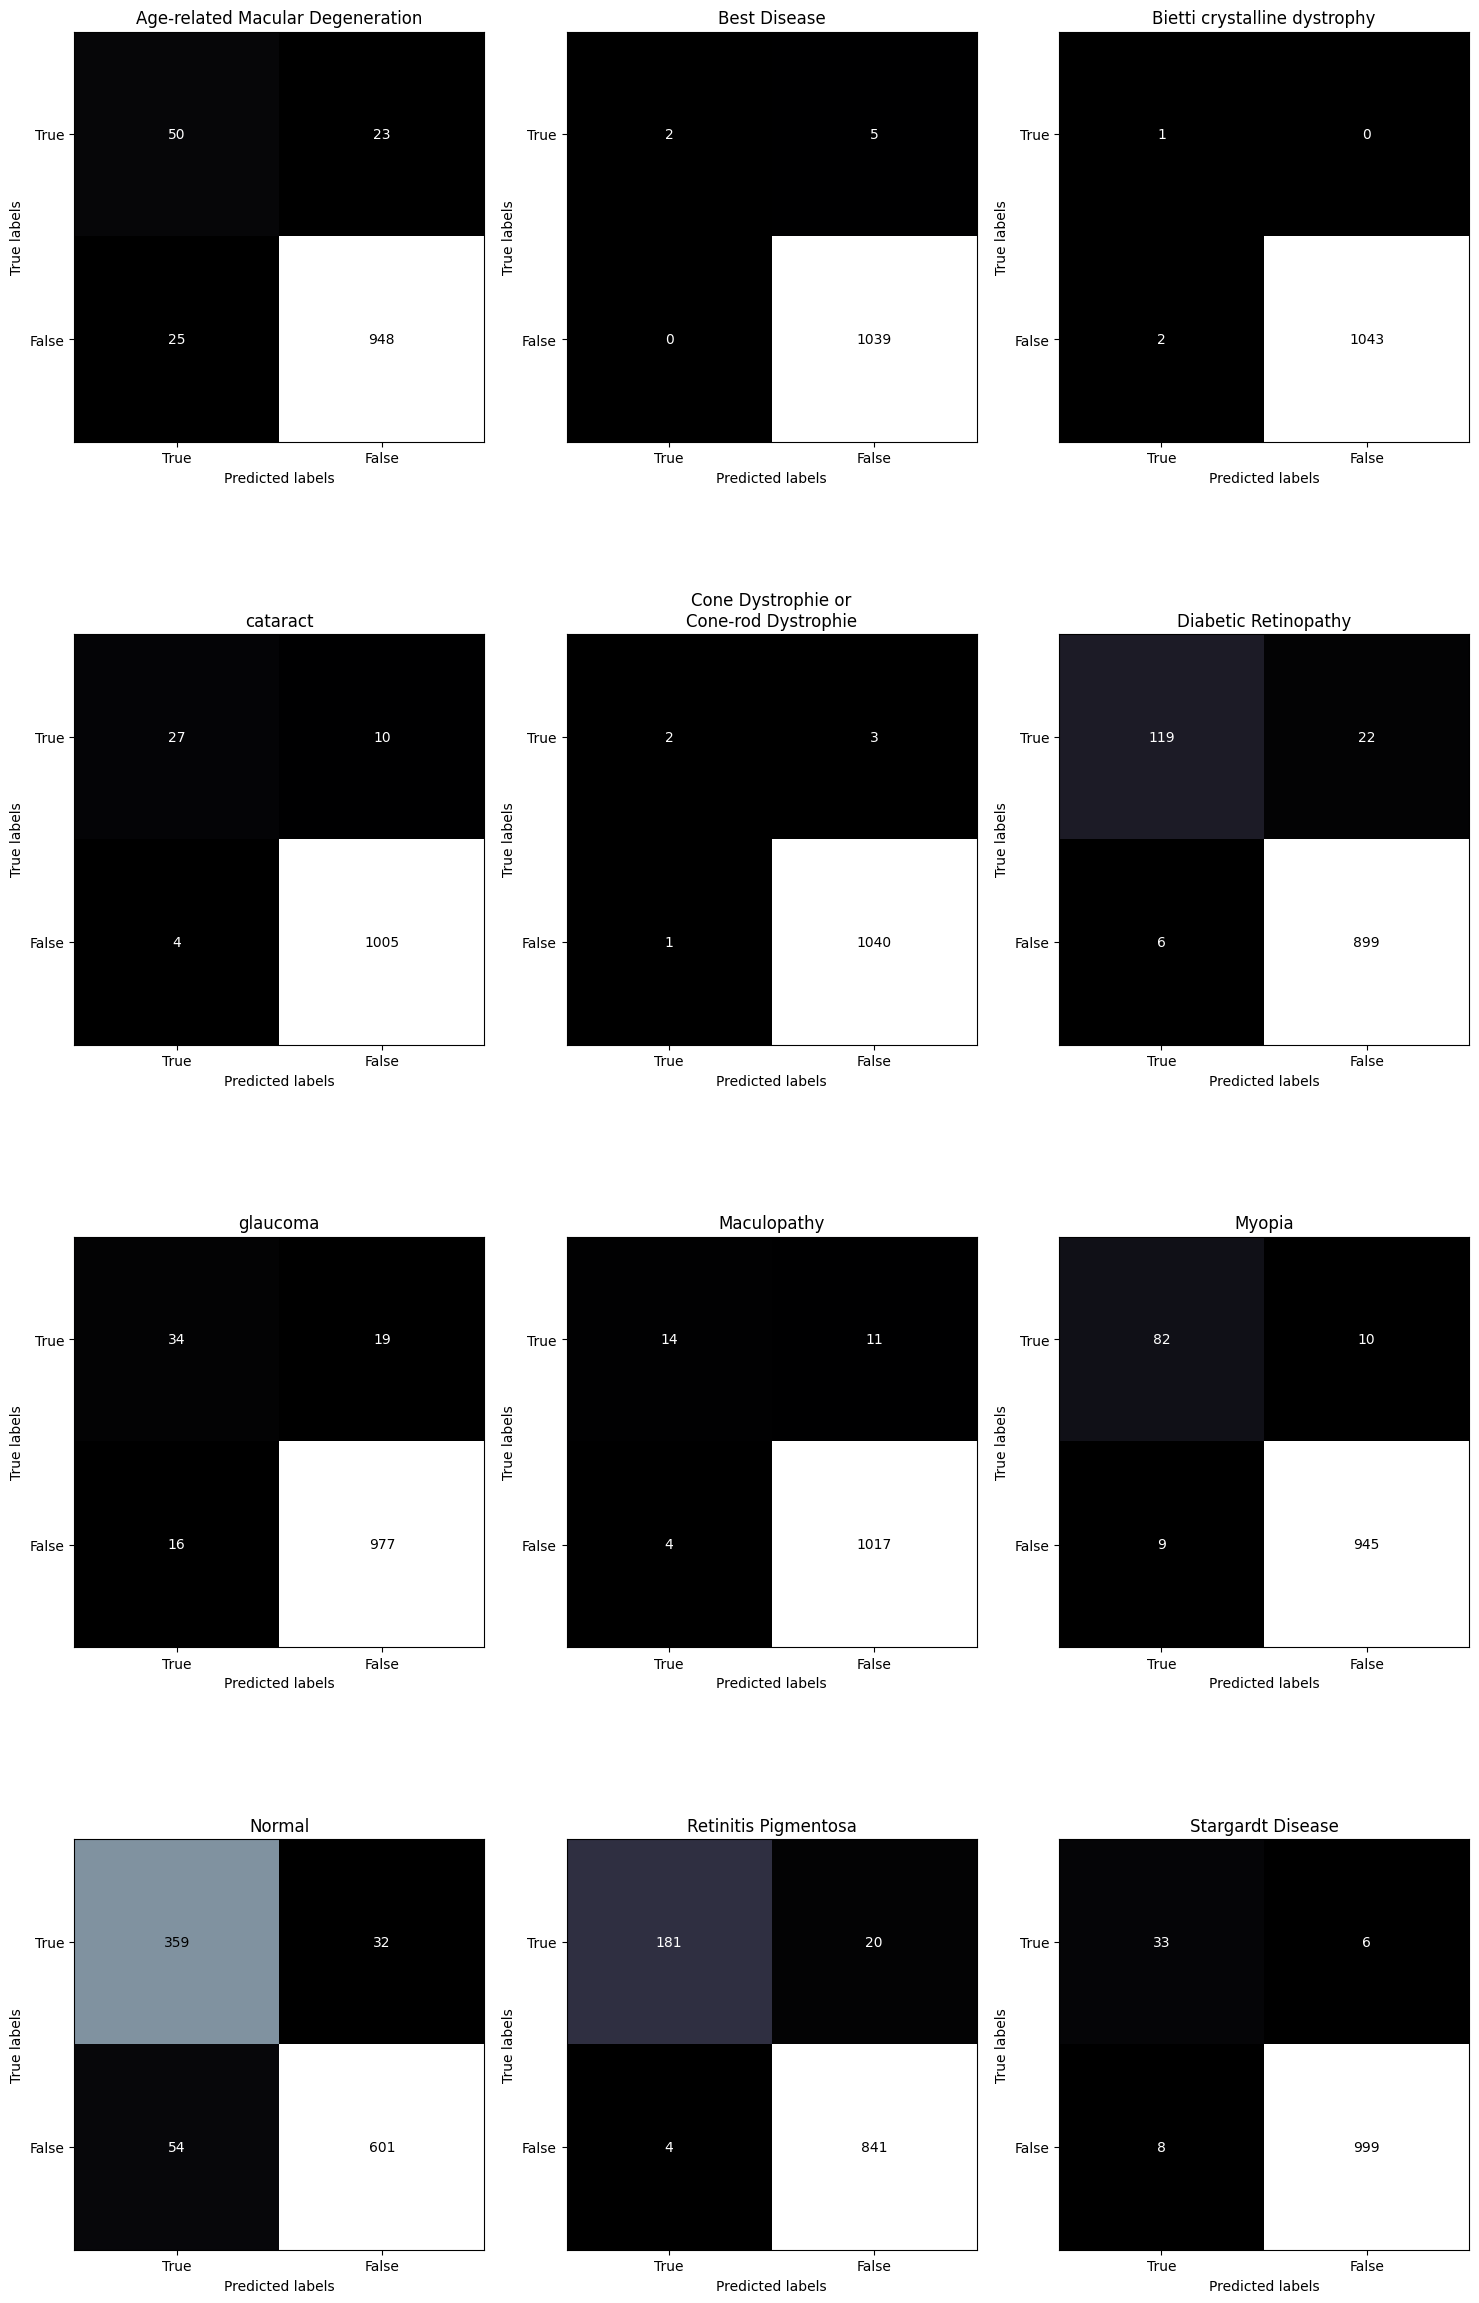

In [20]:
y_pred_cm = torch.sigmoid(y_pred) >best_thresholds
#calculate the confusion matrices on the test set
confusion_matrices = multilabel_confusion_matrix(y_true, y_pred_cm)
flipped_confusion_matrices = np.flip(confusion_matrices, axis=-1)
flipped_confusion_matrices = np.flip(flipped_confusion_matrices, axis=-2)
#plot the confusion matrices, one for each class, 3 per row
n_cols = 3
n_rows = int(np.ceil(len(labels_to_encode) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 30))
axes = axes.flatten()
for i, ax in enumerate(axes):
    #use the confusion matrix to plot the confusion matrix
    cm = confusion_matrices[i]
    disp = ConfusionMatrixDisplay(confusion_matrix=flipped_confusion_matrices[i], display_labels=['True', 'False'])
    #turn off color bar

    disp.plot(ax=ax, colorbar=False, cmap='bone')
    title = labels_to_encode[i]
    #split the title into multiple lines if it is too long
    if title.count(' ') > 2:
        #split every 3rd space
        title = title.split(' ')
        title = [' '.join(title[i:i+3]) for i in range(0, len(title), 3)]
        title = '\n'.join(title)
    ax.set_title(title)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
#save the figure
plt.savefig(f'{evaluations_save_folder}/confusion_matrices.png')

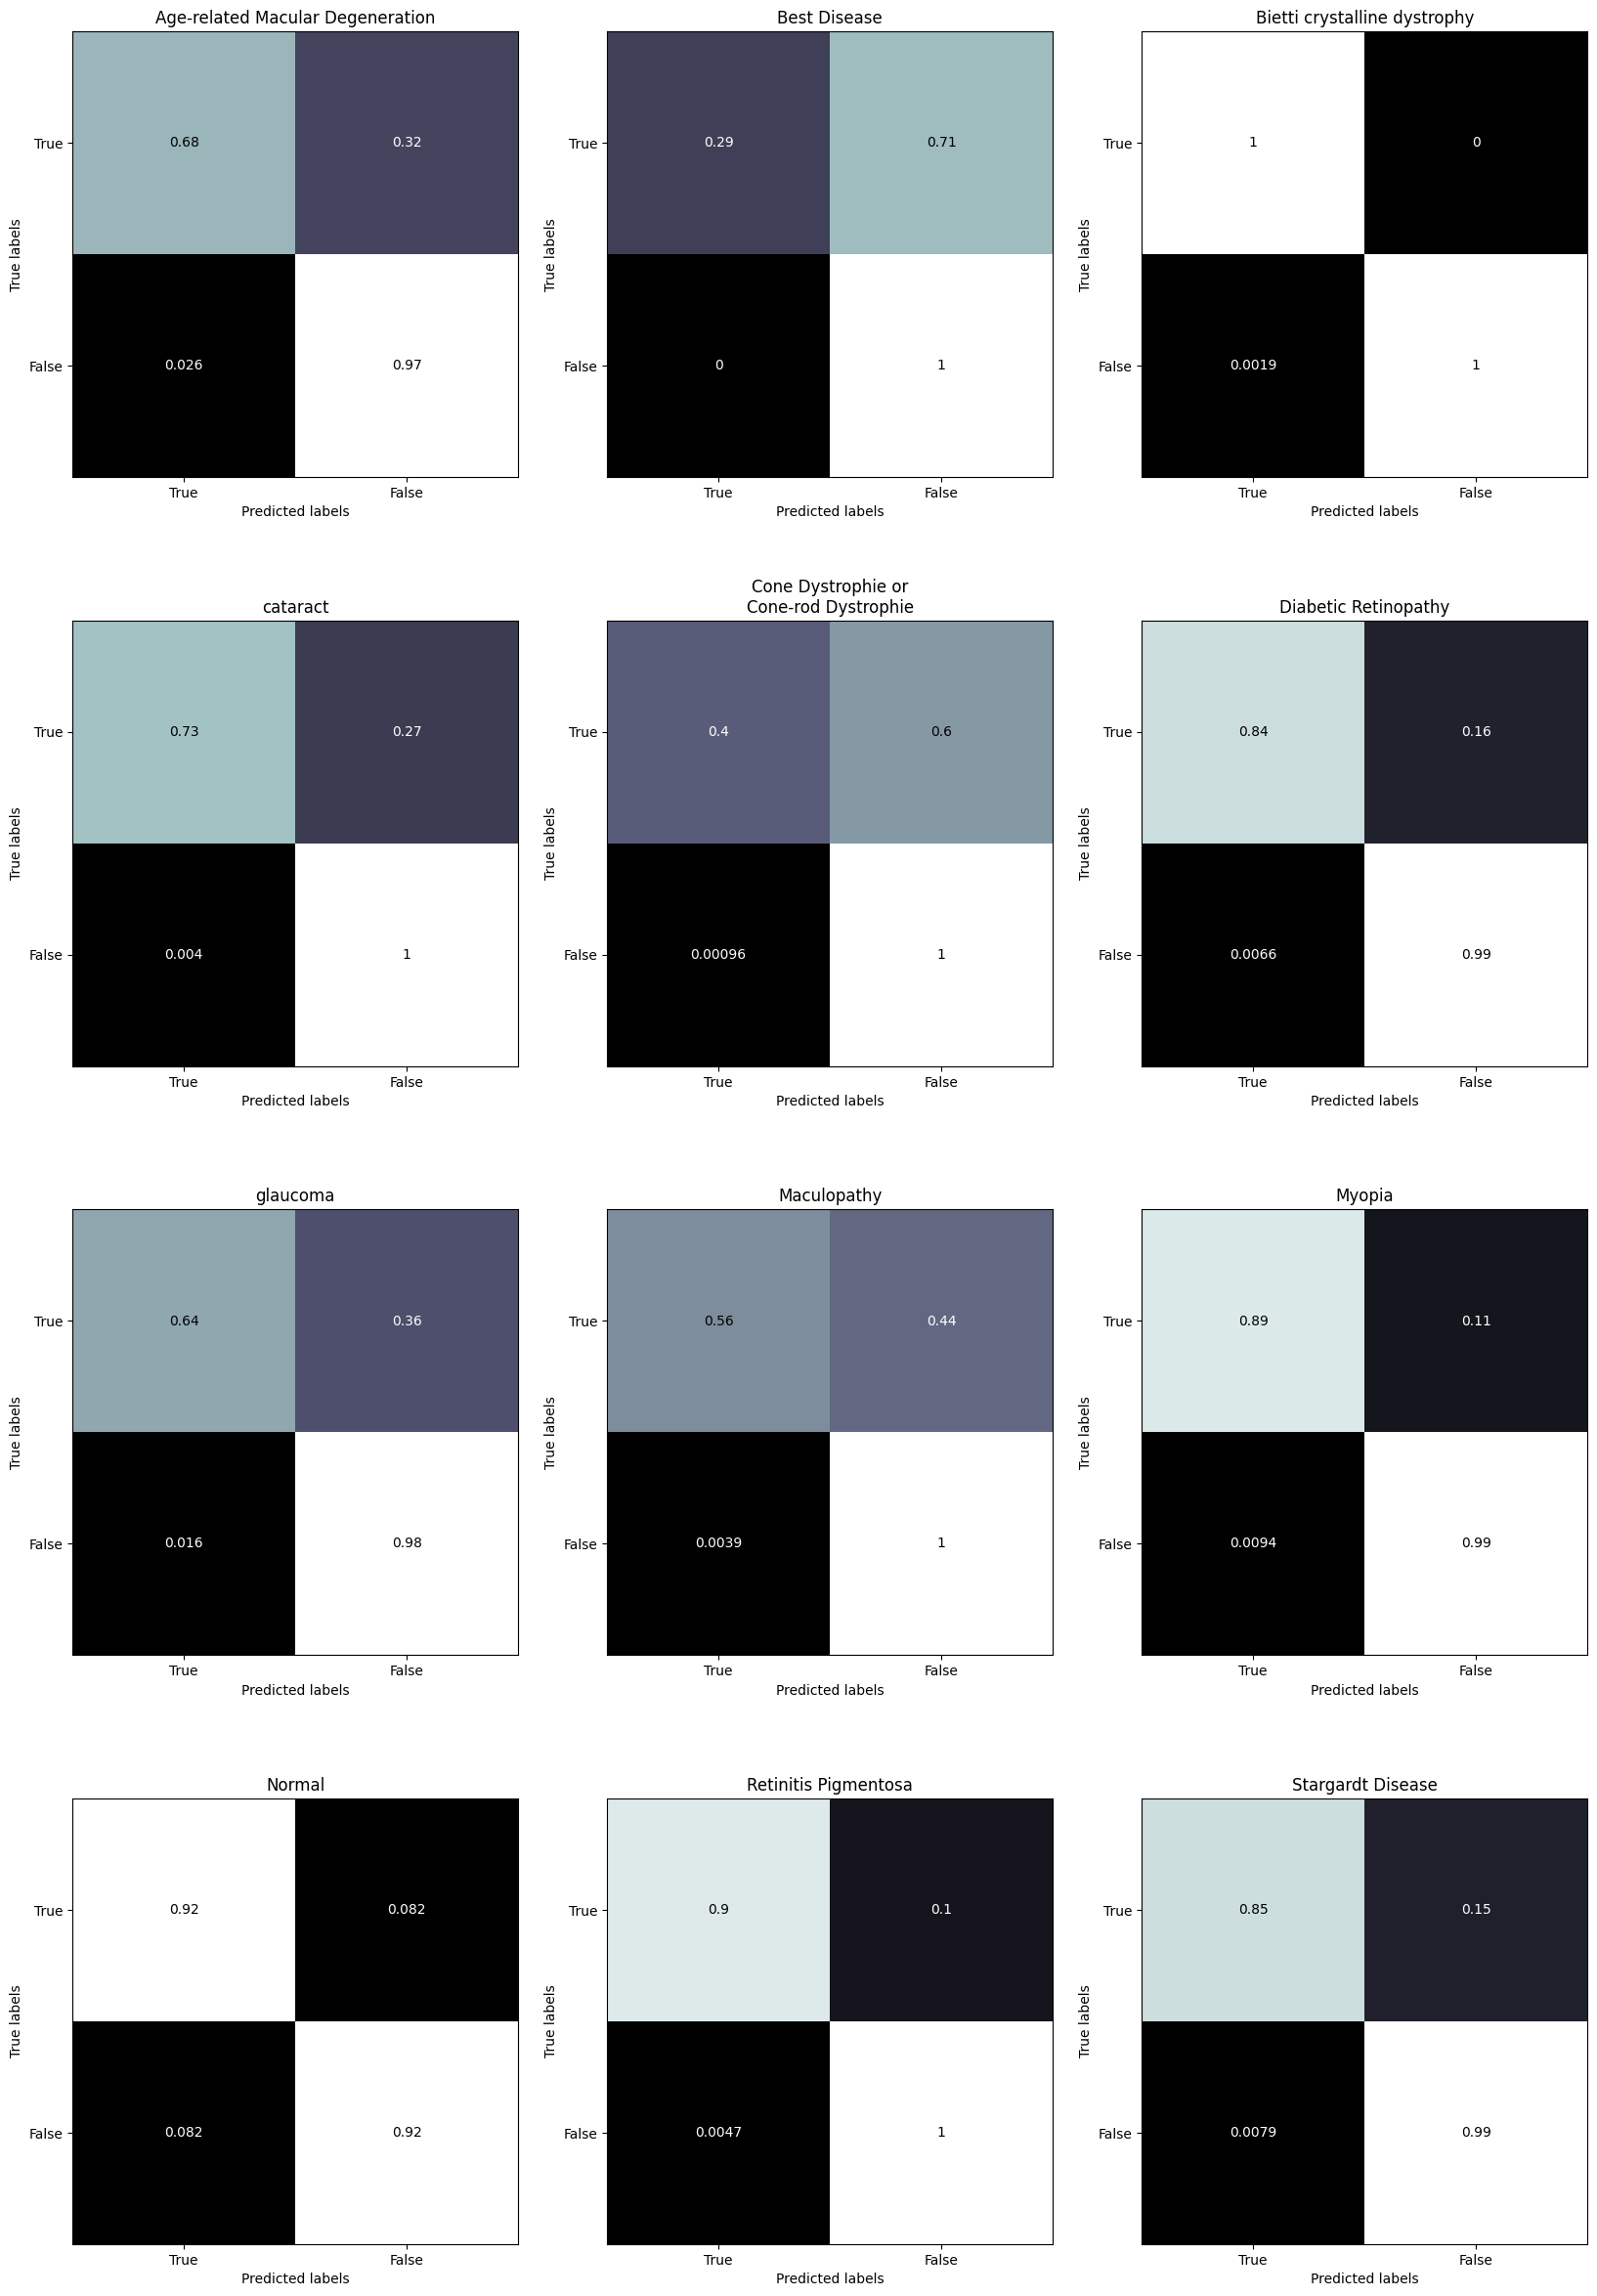

In [21]:
#plot the same confusion matrices with the row normalised values
cm_normalizer = confusion_matrices.sum(axis=2)#[:,np.newaxis]
#add a new dimension to the normalizer
cm_normalizer = cm_normalizer[:,np.newaxis]
#add a copy of the normalizer to the normalizer

#cm_normalizer = np.concatenate([cm_normalizer, cm_normalizer], axis=0)
reversed_normalizer = np.flip(cm_normalizer, axis=-1)
cm_normalizer=np.concatenate([cm_normalizer, reversed_normalizer], axis=1)
#flip the normalizer
cm_normalizer[:,:,1] = cm_normalizer[:,0,:]
normalized_cms = confusion_matrices / cm_normalizer
flipped_normalised_cms = np.flip(np.flip(normalized_cms, axis=-1), axis=-2)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))
axes = axes.flatten()
for i, ax in enumerate(axes):
    #use the confusion matrix to plot the confusion matrix
    cm = confusion_matrices[i]
    disp = ConfusionMatrixDisplay(confusion_matrix=flipped_normalised_cms[i], display_labels=['True', 'False'])
    #turn off color bar

    disp.plot(ax=ax, colorbar=False, cmap='bone')
    title = labels_to_encode[i]
    #split the title into multiple lines if it is too long
    if title.count(' ') > 2:
        #split every 3rd space
        title = title.split(' ')
        title = [' '.join(title[i:i+3]) for i in range(0, len(title), 3)]
        title = '\n'.join(title)
    ax.set_title(title)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    #save the figure
plt.savefig(f'{evaluations_save_folder}/confusion_matrices_normalized.png')

In [22]:
#show how many tp, fp, tn, fn there are in total
tp = confusion_matrices[:, 1, 1]
fp = confusion_matrices[:, 0, 1]
tn = confusion_matrices[:, 0, 0]
fn = confusion_matrices[:, 1, 0]
print(f'TP: {tp.sum()}')
print(f'FP: {fp.sum()}')
print(f'TN: {tn.sum()}')
print(f'FN: {fn.sum()}')
print('-----------------------------------')
best_thresholds = np.array(best_thresholds)
#calculate the precision, recall, accuracy and f1 score
precision_macro = multi_label_precision(y_true, y_pred, threshold=best_thresholds, averaging_type='macro')
recall_macro = multi_label_recal(y_true, y_pred, threshold=best_thresholds, averaging_type='macro')
accuracy_macro = multi_label_accuracy(y_true, y_pred, threshold=best_thresholds, averaging_type='macro')
f1_macro = multi_label_f_beta(y_true, y_pred, beta=1.0, averaging_type='macro', threshold=best_thresholds)
#do the same for the micro scores
precision_micro = multi_label_precision(y_true, y_pred, threshold=best_thresholds, averaging_type='micro')
recall_micro = multi_label_recal(y_true, y_pred, threshold=best_thresholds, averaging_type='micro')
accuracy_micro = multi_label_accuracy(y_true, y_pred, threshold=best_thresholds, averaging_type='micro')
f1_micro = multi_label_f_beta(y_true, y_pred, beta=1.0, averaging_type='micro', threshold=best_thresholds)

#save the evaluation metrics in a dictionary
evaluation_metrics = {
    'precision_macro': precision_macro,
    'recall_macro': recall_macro,
    'accuracy_macro': accuracy_macro,
    'f1_macro': f1_macro,
    'precision_micro': precision_micro,
    'recall_micro': recall_micro,
    'accuracy_micro': accuracy_micro,
    'f1_micro': f1_micro
}
#save the evaluation metrics
with open(f'{evaluations_save_folder}/evaluation_metrics.json', 'w') as f:
    json.dump(evaluation_metrics, f)

TP: 904
FP: 133
TN: 11354
FN: 161
-----------------------------------


In [23]:
#print the evaluation metrics
for key, value in evaluation_metrics.items():
    print(key,':', round(value,2))

precision_macro : 0.79
recall_macro : 0.73
accuracy_macro : 0.98
f1_macro : 0.76
precision_micro : 0.87
recall_micro : 0.85
accuracy_micro : 0.98
f1_micro : 0.86


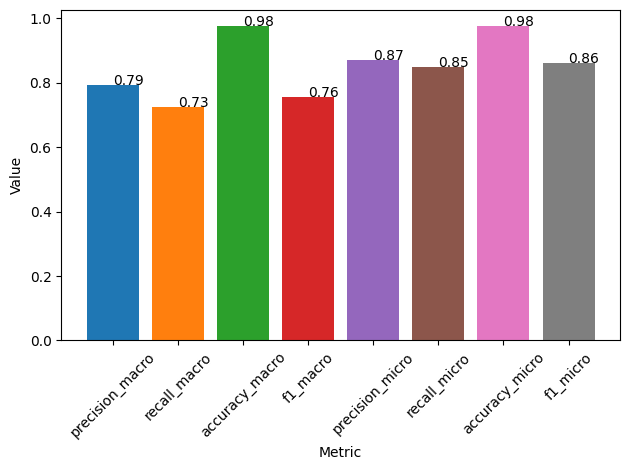

In [24]:
#plot the evaluation metrics
plt.figure()
for metric_name, metric_value in evaluation_metrics.items():
    plt.bar(metric_name, metric_value)
    plt.xticks(rotation=45)
    plt.xlabel('Metric')
    plt.ylabel('Value')
    #annotate the bar with the value
    plt.text(metric_name, metric_value, str(round(metric_value, 2)))
plt.tight_layout()
plt.savefig(f'{evaluations_save_folder}/evaluation_metrics.png')
plt.show()

In [25]:
#calculate the metrics for every test dataset
#best_thresholds = best_thresholds.cpu().numpy()
score_dict = {'data_source' : [], 'f1_micro' : [], 'f1_macro': [], 'precision_micro': [], 'precision_macro': [], 'recall_micro': [], 'recall_macro': [], 'accuracy_micro': [], 'accuracy_macro': []}
for test_dataset, matching_package in zip(test_datasets, test_packages):
    y_true_single = []
    y_pred_single = []
    x_single = []
    model.to(device)
    model.eval()
    single_test_loader = DataLoader(test_dataset, batch_size=164, num_workers=num_workers)
    with torch.no_grad():
        for inputs, labels in single_test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            y_true_single.append(labels.detach().clone())
            y_pred_single.append(outputs.detach().clone())
            x_single.append(inputs.detach().clone())
    y_true_single = torch.cat(y_true_single, dim=0).cpu()
    y_pred_single = torch.cat(y_pred_single, dim=0).cpu()
    x_single = torch.cat(x_single, dim=0).cpu()
    y_pred_single_cm = torch.sigmoid(y_pred_single) > torch.Tensor(best_thresholds)
    #calculate precision, recall, accuracy and f1 score
    precision = multi_label_precision(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='macro')
    recall = multi_label_recal(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='macro')
    accuracy = multi_label_accuracy(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='macro')
    f1 = multi_label_f_beta(y_true_single, y_pred_single, beta=1.0, averaging_type='macro', threshold=best_thresholds)
    #and micro scores
    precision_micro = multi_label_precision(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='micro')
    recall_micro = multi_label_recal(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='micro')
    accuracy_micro = multi_label_accuracy(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='micro')
    f1_micro = multi_label_f_beta(y_true_single, y_pred_single, beta=1.0, averaging_type='micro', threshold=best_thresholds)
    #save the scores
    score_dict['data_source'].append(matching_package.data_source_name)
    score_dict['f1_micro'].append(f1_micro)
    score_dict['f1_macro'].append(f1)
    score_dict['precision_micro'].append(precision_micro)
    score_dict['precision_macro'].append(precision)
    score_dict['recall_micro'].append(recall_micro)
    score_dict['recall_macro'].append(recall)
    score_dict['accuracy_micro'].append(accuracy_micro)
    score_dict['accuracy_macro'].append(accuracy)

#save the scores to a json file
with open(f'{evaluations_save_folder}/break_down_scores.json', 'w') as f:
    json.dump(score_dict, f)


/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:114: RuntimeWarning: invalid value encountered in divide
  recal = true_positives / (true_positives + false_negatives)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:114: RuntimeWarning: invalid value encountered in divide
  recal = true_positives / (true_positives + false_negatives)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (tr

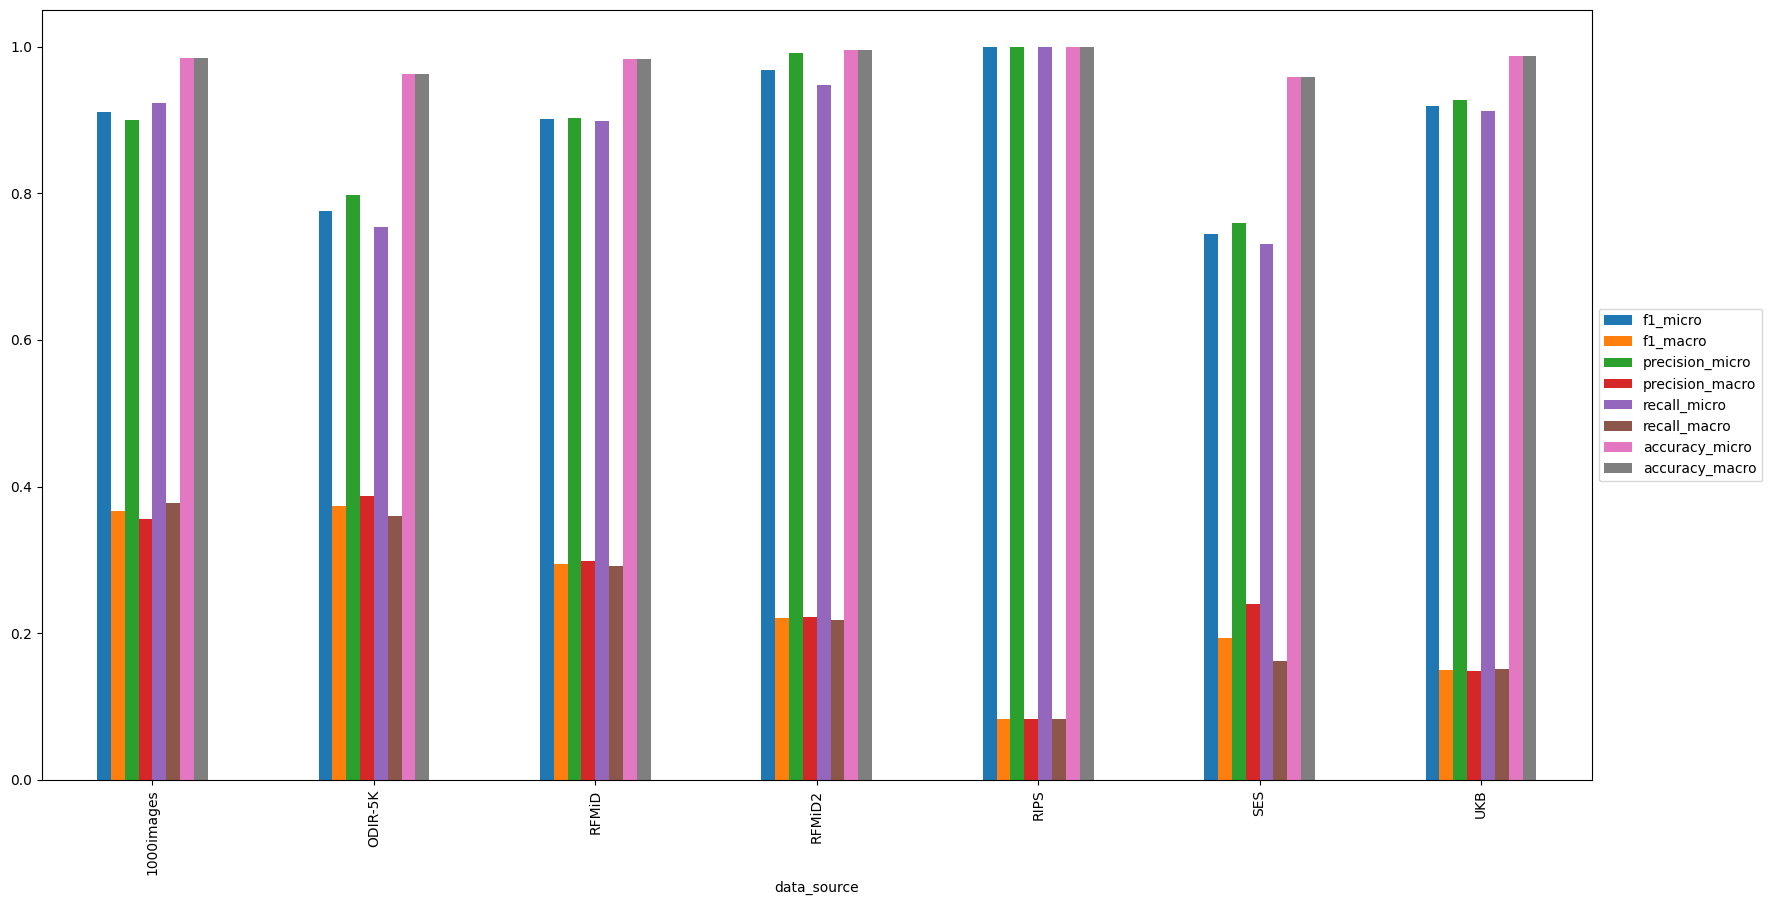

In [27]:
#create a pandas dataframe from the score dict
score_df = pd.DataFrame(score_dict)
#group the scores by data source
grouped_scores = score_df.groupby('data_source').mean()
#plot the grouped scores
grouped_scores.plot(kind='bar', figsize=(20, 10))
plt.savefig(f'{evaluations_save_folder}/grouped_scores.png')
#move the legend outside of the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [29]:
grouped_scores.head()

,f1_micro,f1_macro,precision_micro,precision_macro,recall_micro,recall_macro,accuracy_micro,accuracy_macro
data_source,,,,,,,,
1000images,0.911392,0.366821,0.900000,0.356481,0.923077,0.377778,0.985043,0.985043
ODIR-5K,0.775296,0.373029,0.797297,0.387565,0.754476,0.359543,0.962794,0.962794
RFMiD,0.900853,0.294929,0.903077,0.299226,0.898660,0.291117,0.982955,0.982955
RFMiD2,0.968649,0.220488,0.990741,0.222222,0.948043,0.218801,0.994939,0.994939
RIPS,1.000000,0.083333,1.000000,0.083333,1.000000,0.083333,1.000000,1.000000


In [32]:
score_df.head(20)

,data_source,f1_micro,f1_macro,precision_micro,precision_macro,recall_micro,recall_macro,accuracy_micro,accuracy_macro
0,ODIR-5K,0.775296,0.373029,0.797297,0.387565,0.754476,0.359543,0.962794,0.962794
1,RFMiD,0.887755,0.283684,0.887755,0.287981,0.887755,0.279514,0.980702,0.980702
2,RFMiD,0.920863,0.306965,0.927536,0.301931,0.914286,0.312169,0.986111,0.986111
3,RFMiD,0.893939,0.294138,0.893939,0.307765,0.893939,0.281667,0.982051,0.982051
4,RFMiD2,0.945946,0.165312,0.972222,0.166667,0.921053,0.163978,0.991228,0.991228
5,RFMiD2,1.000000,0.250000,1.000000,0.250000,1.000000,0.250000,1.000000,1.000000
6,RFMiD2,0.960000,0.246154,1.000000,0.250000,0.923077,0.242424,0.993590,0.993590
7,1000images,0.911392,0.366821,0.900000,0.356481,0.923077,0.377778,0.985043,0.985043
8,RIPS,1.000000,0.083333,1.000000,0.083333,1.000000,0.083333,1.000000,1.000000
9,SES,0.745098,0.193795,0.760000,0.240196,0.730769,0.162418,0.958333,0.958333


In [ ]:
precision_macro : 0.79
recall_macro : 0.73
accuracy_macro : 0.98
f1_macro : 0.76
precision_micro : 0.87
recall_micro : 0.85
accuracy_micro : 0.98
f1_micro : 0.86

In [49]:
from torcheval.metrics import MultilabelAccuracy, TopKMultilabelAccuracy

#calculate the metrics for the test dataset
y_pred_torch_metric = torch.sigmoid(y_pred)
accuracy = MultilabelAccuracy(threshold=torch.tensor(best_thresholds), criteria='exact_match')
accuracy.update(y_pred_torch_metric, y_true)
accuracy = accuracy.compute()

top_2_accuracy = TopKMultilabelAccuracy(k=2, criteria='hamming')
top_2_accuracy.update(y_pred, y_true)
top_2_accuracy = top_2_accuracy.compute()

#print the metrics
print('Accuracy:', accuracy)
print('Top 2 accuracy:', top_2_accuracy)



Accuracy: tensor(0.8193)
Top 2 accuracy: tensor(0.9080)
